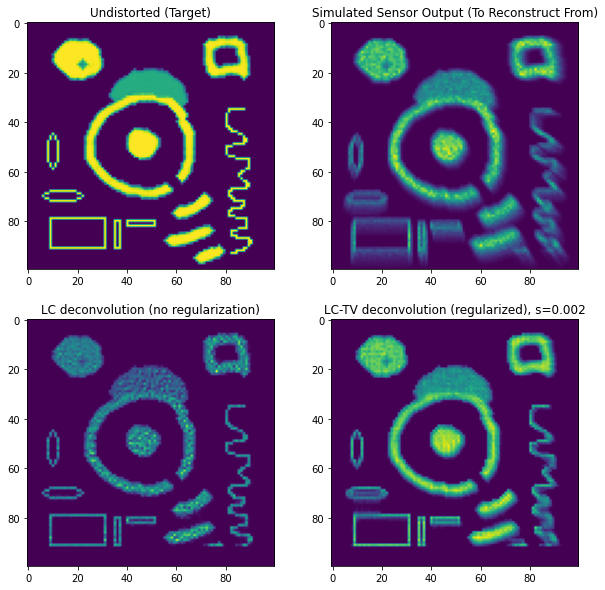

In [24]:
from cupy import meshgrid, linspace
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np

import xtrace

plt.rcParams['figure.figsize'] = [10, 10]

###############################################################################
#information of the frontal intersection point
#hit_col, hit_row and j should be given
hit_col, hit_row = meshgrid(linspace(0, 100, 1000), linspace(0, 100, 1000)) # for 100 rays
#hit_col, hit_row = meshgrid(linspace(0.5, 100-0.5, 2*1000), linspace(0.5, 100-0.5, 2*1000)) # for 1M rays
hit_row = hit_row.flatten()
hit_col = hit_col.flatten()

#pixel dimentions
pl = 75 #pixel length, in micrometers 
pw = 350 #pixel width, in micrometers
ph = 75 #pixel height, in micrometers
det_numpixels = (100, 100)
#To mention:

params = {
    "mu": 3.445930 * 10**-3, #in 1/micron
    "IO": 1,  
    #pixel dimentions
    "pl": pl,
    "pw": pw,
    "ph": ph,
    #detector dimentions
    "det_numpixels": det_numpixels, #number of rows in pixels, number of columns in pixels
    #detector limits in Cartesian coordinates
    "det_xlim": (0.0, pw),
    "det_ylim": (0.0, det_numpixels[1] * pl),
    "det_zlim": (0.0, det_numpixels[0] * ph),

    #Cartesian coordinates of the sample, given by the poni file 
    "sx": -0.4051247560395305 * 10 **4, # -dist in poni file, in micrometers
    "sy": 0.17601077769492505 * 10 **4, # P2 in poni file, in micrometers
    "sz": 0.02184240399163788 * 10 **4, # P1 in poni file, in micrometers

    #for the construction of the plane
    "Jj": 10, # positive or negative integer number related to the plane point
    #positive means either to the right or upwards
    #negative means either to the left or downwards
    #planevec
    #"planevec": np.array([[0,1,0]]), #OBS Unused
}

def regularized_richard_lucy_deconv(img, psf, smooth_coeff, iters):
    pixel_arr = np.array(img).reshape(-1)
    pixel_arr_itr = pixel_arr.copy()
    for _ in range(iters):
        c = psf@pixel_arr_itr
        c[c == 0] = 1
        grad = np.array(np.gradient(pixel_arr_itr.reshape(img.shape)))
        norms = np.sum(np.abs(grad),axis=0)
        norms[norms == 0] = 1
        grad /=norms
        divergence = np.gradient(grad[0],axis=0) + np.gradient(grad[1], axis=1)
        divergence_arr = divergence.reshape(-1)
        sm = psf.T@(pixel_arr/c)
        pixel_arr_itr = pixel_arr_itr*sm/(1 - smooth_coeff*divergence_arr) 
    return pixel_arr_itr.reshape(img.shape)


G = xtrace.sensor_depth_spill_psf(params, hit_row, hit_col)

img = image.imread("example_image.png").sum(axis=2)
img = img - img.min()

distorted_img = (G.get()@img.flatten()).reshape(img.shape)
perc, lam = (0.7, 10)
distorted_img = distorted_img * (perc + np.random.poisson(lam, distorted_img.shape)/lam*(1 - perc))

recovered_img = xtrace.regularized_richard_lucy_deconv(distorted_img, G, 0, 100).get()
smooth = 0.002
recovered_img_tv = xtrace.regularized_richard_lucy_deconv(distorted_img, G, smooth, 100).get()
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(img)
axs[0, 0].set_title("Undistorted (Target)")
axs[0, 1].imshow(distorted_img)
axs[0, 1].set_title("Simulated Sensor Output (To Reconstruct From)")
axs[1, 0].imshow(recovered_img)
axs[1, 0].set_title("LC deconvolution (no regularization)")
axs[1, 1].imshow(recovered_img_tv)
axs[1, 1].set_title(f'LC-TV deconvolution (regularized), s={smooth}')
plt.show()
